In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import skimage as skimage
import scipy as scipy

import scipy.ndimage

import cv2 as cv

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
%config InlineBackend.figure_format ='retina'

plt.rcParams.update({'font.size': 35})

### Read Image

In [3]:
# from skimage.draw import circle_perimeter_aa

# raw_image = np.zeros((500, 500)).astype(np.float32)

# rr, cc, val = circle_perimeter_aa(150, 150, 100)
# raw_image[rr, cc] = val

# rr, cc, val = circle_perimeter_aa(350, 300, 50)
# raw_image[rr, cc] = val

# raw_image = raw_image * 255

# ########################################################################

# plt.imshow(raw_image, cmap = 'binary', vmin = 0, vmax = 255)

# plt.colorbar()

# plt.tight_layout()

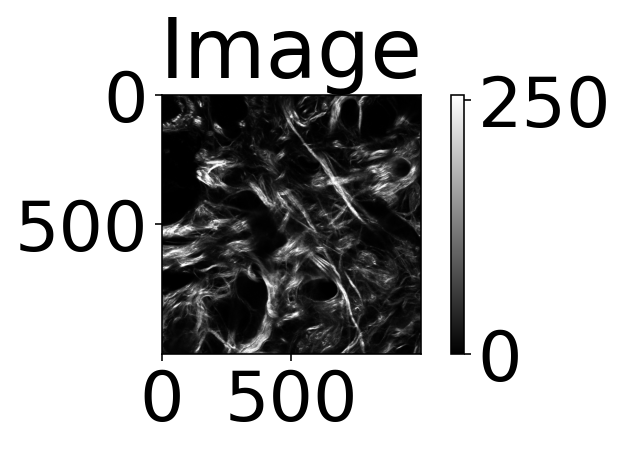

In [4]:
# raw_image = skimage.io.imread('aligned_fibres.tif', as_gray = True).astype('float32')

# raw_image = raw_image[400:600, 400:600]

########################################################################

# raw_image = skimage.io.imread('Tumour.tif').astype('float32')
# 
# raw_image = skimage.io.imread('Healthy.tif').astype('float32')

# raw_image = raw_image.max(axis = 0) # Max projection

########################################################################

raw_image = skimage.io.imread('Left.tif').astype('float32')

# raw_image = skimage.io.imread('Right.tif').astype('float32')

########################################################################

plt.imshow(raw_image, cmap = 'gray')

plt.title('Image')

plt.colorbar()

# plt.xticks([])

# plt.yticks([])

plt.tight_layout()

In [5]:
raw_image.shape

(1000, 1000)

### Create Image of same dimensions in X and Y

In [6]:
# raw_image = np.zeros((max(image.shape), max(image.shape)))

# raw_image[:len(image)] = image

In [7]:
# plt.imshow(raw_image, cmap = 'gray')

# plt.colorbar()

# # plt.xticks([])

# # plt.yticks([])

# plt.tight_layout()

### Create HeatMap

In [8]:
def make_HeatMap(input_image, heatmap_windows):

    # Define the local ROI

    local_region = skimage.morphology.rectangle(int(input_image.shape[0] / heatmap_windows), 
                                                int(input_image.shape[1] / heatmap_windows) )

    heatmap_image = skimage.filters.rank.mean(skimage.util.img_as_ubyte(input_image / input_image.max()), 
                                              footprint = local_region)

    return heatmap_image

### Make 2D Structure Tensor from Image

In [9]:
def make_StructureTensor2D(input_image, filter_sigma, window_size):

    ### Calculate image gradients

    filtered_image = skimage.filters.gaussian(input_image, sigma = filter_sigma, mode = 'nearest')

    image_gradient_x = scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'nearest')

    image_gradient_y = scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'nearest')
    
#     image_gradient_x = scipy.ndimage.gaussian_filter(raw_image, filter_sigma, order = [0, 1])

#     image_gradient_y = scipy.ndimage.gaussian_filter(raw_image, filter_sigma, order = [1, 0])

    #########################################################################################################

    ### Calculate Jxx, Jyy and Jxy

    Jxx = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_x, window_size)

    Jyy = scipy.ndimage.gaussian_filter(image_gradient_y * image_gradient_y, window_size)

    Jxy = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_y, window_size)
    
    #########################################################################################################

    ### Make Structure Tensor

    Raw_Structure_Tensor = np.array([[Jxx, Jxy], 
                                     [Jxy, Jyy]])

    Structure_Tensor = np.moveaxis(Raw_Structure_Tensor, [0, 1], [2, 3]) # For solving eigenproblem

    #########################################################################################################
    
    ### Calculate Energy

    Energy = np.trace(Raw_Structure_Tensor)

    #########################################################################################################
    
    return Structure_Tensor, Jxx, Jyy, Jxy, Energy

In [10]:
def solve_EigenProblem(Structure_Tensor):
    
    ## Solve EigenValue problem

    EigenValues, EigenVectors = np.linalg.eigh(Structure_Tensor)

    #########################################################################################################

    return EigenValues, EigenVectors

### Calculate Orientation vector field, Orientation and Coherance

In [11]:
def make_Coherance_Orientation(input_image, EigenValues, Structure_Tensor, Jxx, Jyy, Jxy):
    
    Coherance_Array = np.zeros(input_image.shape)
    
    vx = np.zeros(input_image.shape)
    
    vy = np.zeros(input_image.shape)

    ### Calculate Coherance and Orientation vector field

    Coherance_Array = np.zeros(input_image.shape)

    #############################################

    for j in range(input_image.shape[1]):

        for i in range(input_image.shape[0]):
            
            #############################################
            
            ### Calculate vector field of orientations

            vx[i, j] = EigenVectors[i, j][:, 0][0]

            vy[i, j] = EigenVectors[i, j][:, 0][1]

            #############################################
            
            ### Calculate Coherance

            if ( (EigenValues[i, j].sum()) > 0):

                Smallest_Normalized_Eigenvalues = EigenValues[i, j][0] / np.matrix.trace(Structure_Tensor[i, j])

                Largest_Normalized_Eigenvalues = EigenValues[i, j][1] / np.matrix.trace(Structure_Tensor[i, j])

                Coherance_Array[i, j] = np.abs((Smallest_Normalized_Eigenvalues - Largest_Normalized_Eigenvalues) /
                                               (Smallest_Normalized_Eigenvalues + Largest_Normalized_Eigenvalues))

            else:

                Coherance_Array[i, j] = 0

    ### Normalize Coherance between 0 and 1

    Coherance = cv.normalize(Coherance_Array, None, alpha = 1e-3, beta = 1, 
                             norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

    #############################################
    
    ### Calculate Orientation

    Raw_Orientation_Array = 0.5 * ( cv.phase( (Jyy - Jxx), (2 * Jxy), angleInDegrees = True) )

    #############################################
    
    ### Normalize Orientation between 0 and 180

    Orientation = cv.normalize(Raw_Orientation_Array, None, alpha = 0., beta = 180, 
                               norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

    return Coherance, Orientation, vx, vy

### Start the procedure

In [12]:
raw_image.shape

(1000, 1000)

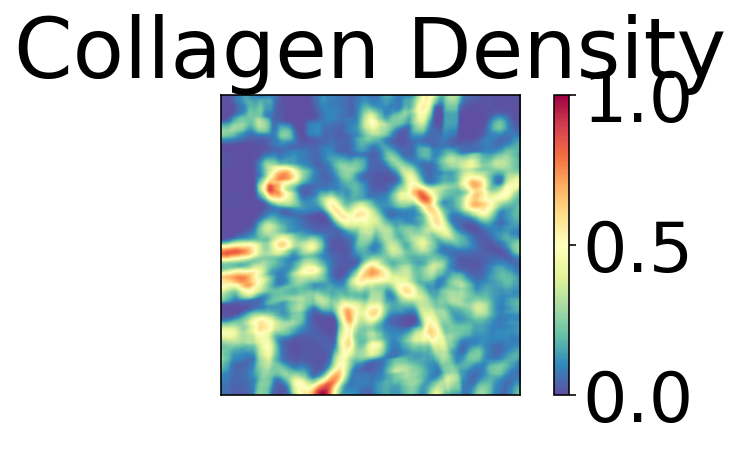

In [13]:
heatmap_averaging_windows = 20

heatmap_image = make_HeatMap(raw_image, heatmap_averaging_windows)

plt.imshow(heatmap_image / heatmap_image.max(), cmap = 'Spectral_r', vmin = 0, vmax = 1)

plt.colorbar()

plt.xticks([])

plt.yticks([])

plt.title('Collagen Density')

plt.tight_layout()

In [14]:
filter_sigma = 2

ROI_size = max(int(0.007 * min(raw_image.shape)), 2)

print(filter_sigma, ROI_size)

print()

2 7



In [15]:
# Make Structure_Tensor

Structure_Tensor, Jxx, Jyy, Jxy, Energy = make_StructureTensor2D(raw_image, filter_sigma, ROI_size)

# Solve the EigenProblem

EigenValues, EigenVectors = solve_EigenProblem(Structure_Tensor)

# Calculate Orientation, Coherance

Coherance, Orientation, vx, vy = make_Coherance_Orientation(raw_image, EigenValues, Structure_Tensor, 
                                                            Jxx, Jyy, Jxy)

In [16]:
Energy.shape

(1000, 1000)

### Plot Orientation and Coherance

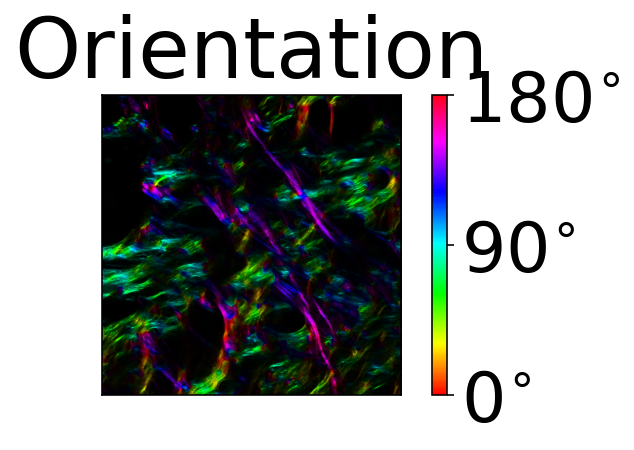

In [17]:
plt.imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation/180), 
           vmin = 0, vmax = 1, cmap = 'hsv')

########################################################################

# Orientation_heatmap = skimage.filters.gaussian(Orientation/180, sigma = 1)

# plt.imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation_heatmap), 
#            vmin = 0, vmax = 1, cmap = 'hsv')

########################################################################

cbar = plt.colorbar(ticks = [0, 0.5, 1])
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])
# cbar.ax.invert_yaxis()

plt.title('Orientation')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

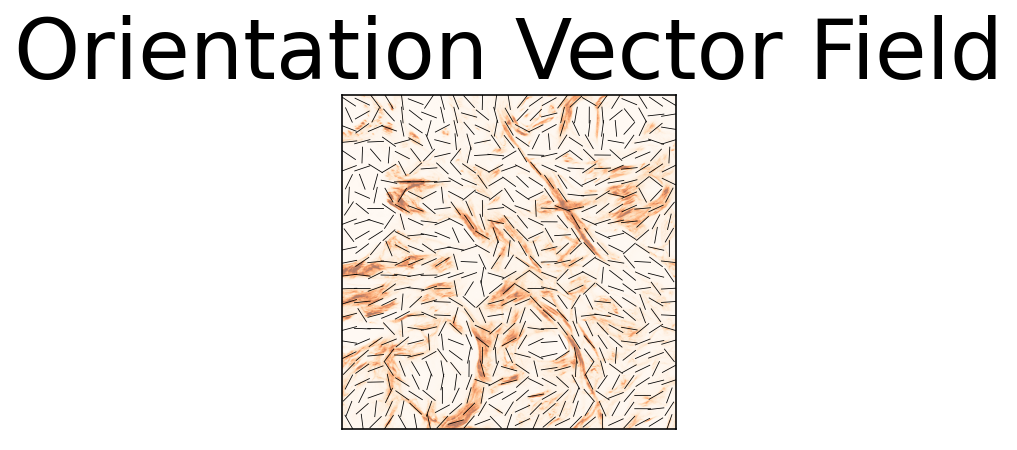

In [18]:
plt.imshow(raw_image, cmap = 'Oranges', alpha = 0.6)

spacing = 40

scale = 20

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

plt.quiver(ymesh[spacing//2::spacing, spacing//2::spacing], 
           xmesh[spacing//2::spacing, spacing//2::spacing],
           vy[spacing//2::spacing, spacing//2::spacing], 
           vx[spacing//2::spacing, spacing//2::spacing],
           scale = scale, headlength = 0, headaxislength = 0, 
           pivot = 'middle', color = 'k', angles = 'xy')

##################

plt.title('Orientation Vector Field')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

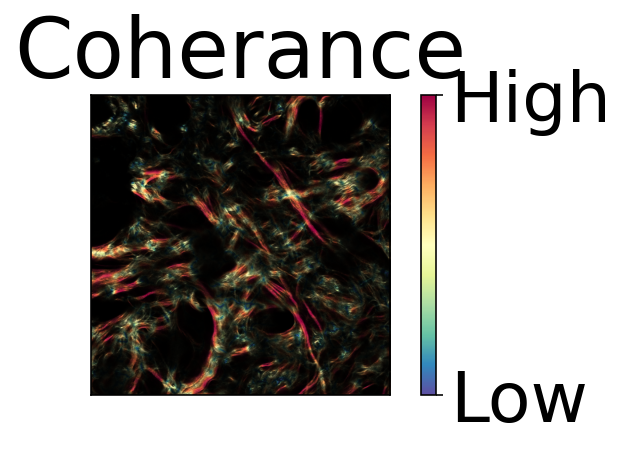

In [19]:
plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Coherance), 
           vmin = 0, vmax = 1, cmap = 'Spectral_r')

########################################################################

# Coherance_heatmap = skimage.filters.gaussian(Coherance, sigma = 1)

# plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Coherance_heatmap), 
#            vmin = 0, vmax = 1, cmap = 'Spectral_r')

########################################################################

cbar = plt.colorbar(ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])

plt.title('Coherance')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

In [20]:
# Crosslink_Density = np.copy(Coherance)

# Crosslink_Density[np.where(Coherance > 0.1)] = 0

# # Crosslink_Density_with_Image = Crosslink_Density * raw_image

In [21]:
# plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Crosslink_Density / Crosslink_Density.max()), 
#            vmin = 0, vmax = 1, cmap = 'Spectral_r')

# ########################################################################

# cbar = plt.colorbar(ticks = [0, 1])
# cbar.ax.set_yticklabels(['High', 'High'])

# plt.title('Crosslink Density')

# plt.xticks([])

# plt.yticks([])

# plt.tight_layout()

In [22]:
# Coherance.min(), Coherance.max()

In [23]:
# Crosslink_Density = 1/Coherance

In [24]:
# Crosslink_Density.min(), Crosslink_Density.max()

In [25]:
# plt.imshow(Crosslink_Density)

In [26]:
# plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Crosslink_Density), 
#            vmin = 0.9*Crosslink_Density.max(), vmax = Crosslink_Density.max(), cmap = 'Spectral_r')

# ########################################################################

# # Coherance_heatmap = skimage.filters.gaussian(Coherance, sigma = 1)

# # plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Coherance_heatmap), 
# #            vmin = 0, vmax = 1, cmap = 'Spectral_r')

# ########################################################################

# plt.colorbar()

# # cbar = plt.colorbar(ticks = [0, 1])
# # cbar.ax.set_yticklabels(['Low', 'High'])

# plt.title('Crosslink Density')

# plt.xticks([])

# plt.yticks([])

# plt.tight_layout()

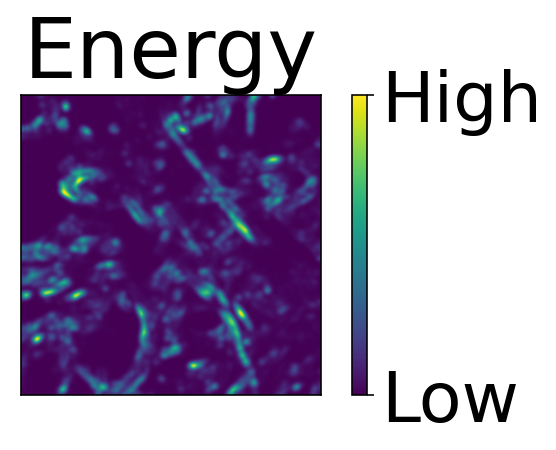

In [27]:
# Energy_heatmap = skimage.filters.gaussian(Energy, sigma = 1)

# plt.imshow(Energy_heatmap / Energy_heatmap.max(), vmin = 0, vmax = 1, cmap = 'viridis')

plt.imshow(Energy / Energy.max(), vmin = 0, vmax = 1, cmap = 'viridis')

########################################################################

cbar = plt.colorbar(ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])

plt.title('Energy')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

### Plot everything together

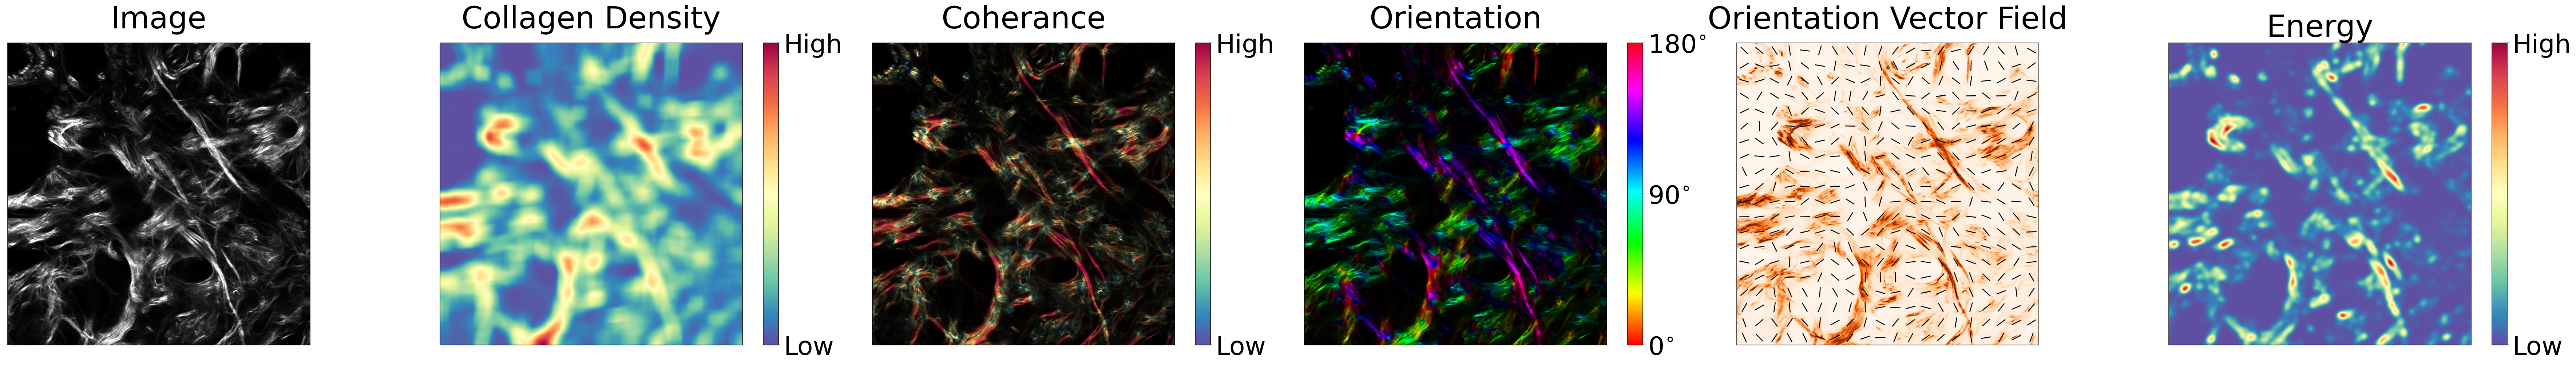

In [28]:
fig, ax = plt.subplots(1, 6, figsize = (50, 10), sharex = True, sharey = True)

ax[0].imshow(raw_image, cmap = 'binary_r')
ax[0].set_title('Image', pad = 20)
ax[0].set_xticks([])
ax[0].set_yticks([])
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.4)
cax0.remove()

########################################################################

im1 = ax[1].imshow(heatmap_image / heatmap_image.max(), cmap = 'Spectral_r', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im1, cax=cax1, ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])

ax[1].set_title('Collagen Density', pad = 20)
ax[1].set_xticks([])
ax[1].set_yticks([])

########################################################################

im2 = ax[2].imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Coherance), 
                   vmin = 0, vmax = 1, cmap = 'Spectral_r')
# im2 = ax[2].imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.Spectral_r(Coherance_heatmap), 
#                    vmin = 0, vmax = 1, cmap = 'Spectral_r')

divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im1, cax=cax2, ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])
ax[2].set_title('Coherance', pad = 20)
ax[2].set_xticks([])
ax[2].set_yticks([])

########################################################################

im3 = ax[3].imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation/180), 
                   vmin = 0, vmax = 1, cmap = 'hsv')
# im3 = ax[3].imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation_heatmap), 
#                    vmin = 0, vmax = 1, cmap = 'hsv')

divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im3, cax=cax3, ticks = [0, 0.5, 1])
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])

ax[3].set_title('Orientation', pad = 20)
ax[3].set_xticks([])
ax[3].set_yticks([])

########################################################################

im4 = ax[4].imshow(raw_image, cmap = 'Oranges', alpha = 1)

spacing = 50

scale = 30

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

ax[4].quiver(ymesh[spacing//2::spacing, spacing//2::spacing], 
           xmesh[spacing//2::spacing, spacing//2::spacing],
           vy[spacing//2::spacing, spacing//2::spacing], 
           vx[spacing//2::spacing, spacing//2::spacing],
           scale = scale, headlength = 0, headaxislength = 0, 
           pivot = 'middle', color = 'k', angles = 'xy')

ax[4].set_title('Orientation Vector Field', pad = 20)
ax[4].set_xticks([])
ax[4].set_yticks([])

divider = make_axes_locatable(ax[4])
cax = divider.append_axes("right", size="5%", pad=0.4)
cax.remove()

########################################################################

im5 = ax[5].imshow(Energy/ Energy.max(), vmin = 0, vmax = 1, cmap = 'Spectral_r')

divider = make_axes_locatable(ax[5])
cax5 = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im1, cax=cax5, ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])
ax[5].set_title('Energy')
ax[5].set_xticks([])
ax[5].set_yticks([])

########################################################################

fig.tight_layout()

plt.savefig('Analysis.pdf')

In [29]:
raw_image.shape

(1000, 1000)

In [30]:
# number_otsu_windows = 100

# footprint = skimage.morphology.square(int(min(raw_image.shape) / number_otsu_windows))

# filtered_image = skimage.filters.median(raw_image)

# local_otsu_values = skimage.filters.rank.otsu(skimage.util.img_as_ubyte(filtered_image / filtered_image.max()), 
#                                               footprint = footprint)

# local_thresholded_image = filtered_image >= local_otsu_values

In [31]:
filtered_image = skimage.filters.gaussian(raw_image, sigma = 2)

thresholded_image = skimage.filters.threshold_otsu(filtered_image)

binarized_image = filtered_image > thresholded_image

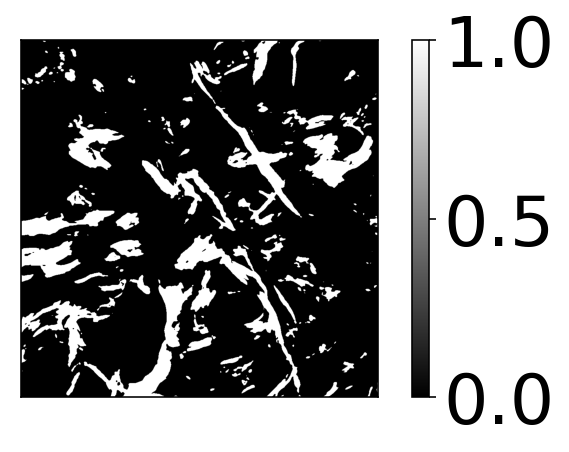

In [32]:
plt.imshow(binarized_image, vmin = 0, vmax = 1, cmap = 'binary_r')

########################################################################

# cbar = plt.colorbar(ticks = [0, 1])
# cbar.ax.set_yticklabels(['Low', 'High'])

plt.colorbar()

plt.xticks([])

plt.yticks([])

plt.tight_layout()

In [33]:
selection = raw_image.copy()

selection[~binarized_image] = 0

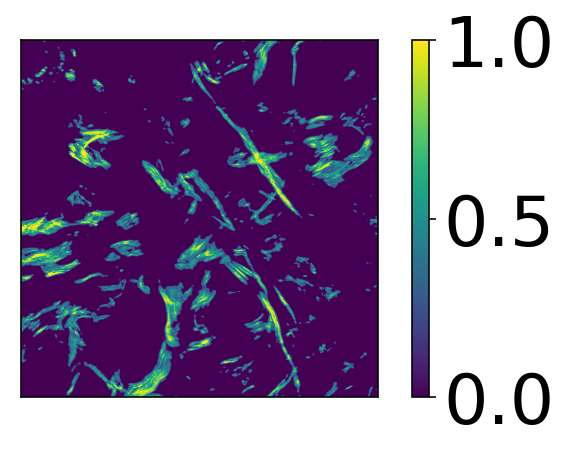

In [34]:
plt.imshow(selection / selection.max(), vmin = 0, vmax = 1, cmap = 'viridis')

########################################################################

plt.colorbar()

plt.xticks([])

plt.yticks([])

plt.tight_layout()

In [35]:
array = binarized_image * Orientation

In [36]:
array[binarized_image == False] = np.nan

In [37]:
data, bins = np.histogram((array), bins = 100, range = [1e-2, 180], density = False)

(0.0, 4121.25)

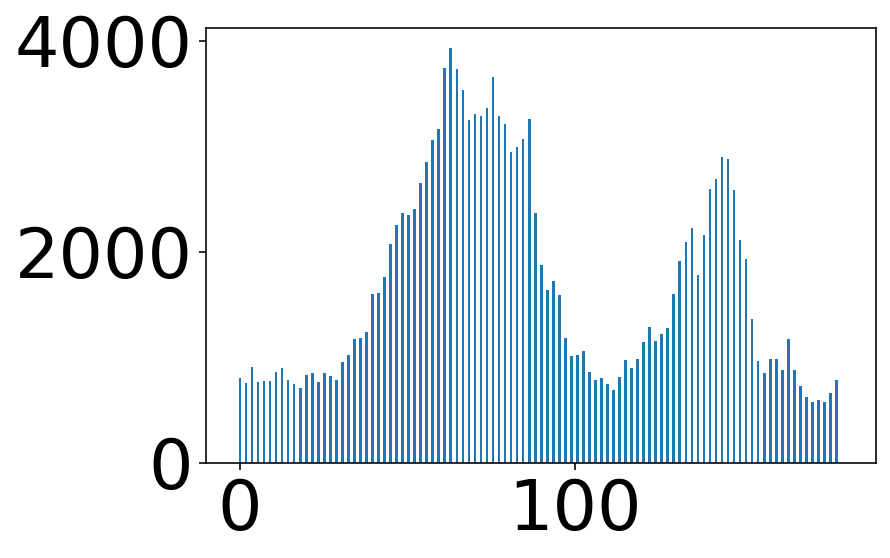

In [38]:
plt.bar(bins[0:len(bins) - 1], data)

plt.xlim(-10, 190)

plt.ylim(0,)

In [39]:
array = binarized_image * Coherance

In [40]:
array[binarized_image == False] = np.nan

In [41]:
data, bins = np.histogram((array), bins = 100, range = [1e-2, 1], density = True)

(0.0, 2.0786660537415917)

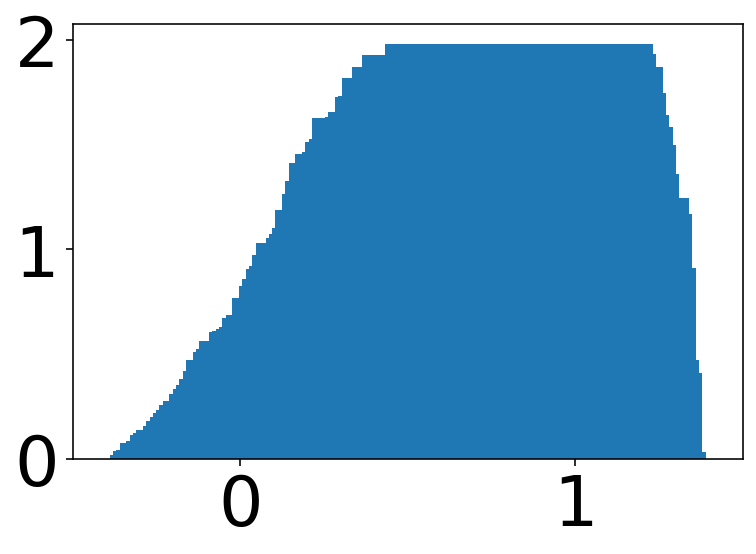

In [42]:
plt.bar(bins[0:len(bins) - 1], data)

plt.xlim(-0.5, 1.5)

plt.ylim(0,)